In [8]:
#Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler

#Data preprocessing
data = pd.read_csv('LoanStats3b.csv',skiprows=1,low_memory=False)
data = data.drop([data.index[len(data)-1], data.index[len(data)-2]])
c = []
#Dropping columns filled with more than half null values
data = data.dropna(thresh = len(data)*9/10,axis=1)
#Removing redundant and irrelevant columns
#Removing columns which have same values throughout
del_col = ['funded_amnt_inv','emp_title','pymnt_plan','title','zip_code','out_prncp','out_prncp_inv','funded_amnt','total_pymnt_inv','policy_code','application_type','delinq_amnt','hardship_flag','debt_settlement_flag','earliest_cr_line','last_pymnt_d','last_credit_pull_d','revol_util']
data = data.drop(labels = del_col,axis=1)

#Removing percentage from rate
#Selecting month from date and no of months from term
data.iloc[:,2] = data.iloc[:,2].apply(lambda x: float(x[:-1]))
data.iloc[:,1] = data.iloc[:,1].apply(lambda x: float(x[:-7]))
data.iloc[:,10] = data.iloc[:,10].apply(lambda x:(x[:-5]))

#Converting employed length to numerical form
data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
data["emp_length"] = data["emp_length"].apply(lambda x:float(x))
#Converting months to numerical form
month = {'Jan':1, 'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6,'Jul':7,'Aug':8,'Sep':9, 'Oct':10,'Nov':11, 'Dec':12}
data['issue_d'] = data['issue_d'].replace(month)
data['issue_d'] = data['issue_d'].apply(lambda x:int(x))
#Converting the output from labels to classes
data = data[(data['loan_status']=="Fully Paid") | (data['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
data= data.replace({"loan_status": di})
data = data[[c for c in data if c not in ['loan_status']] + ['loan_status']]
#Converting categorical data to numerical form
string_label = ['grade','sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status']
for i in string_label:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

#Applying standardization
scl = StandardScaler()
fields = data.columns.values[:-1]
#Filling null values by mean
data.fillna(data.mean(),inplace = True)

data_clean = pd.DataFrame(scl.fit_transform(data[fields]), columns = fields)


data_clean['loan_status'] = data['loan_status']

data_clean['loan_status'].fillna(0, inplace=True)

data_clean.to_csv('loanCleaned.csv')
print(data.shape)

(188180, 44)


In [9]:
cor = data_clean.corr()
cor_target = abs(cor['loan_status'])
relevant_features = cor_target[cor_target>0.05]
print(cor_target)

loan_amnt                     0.002726
term                          0.003856
int_rate                      0.009593
installment                   0.002980
grade                         0.008820
sub_grade                     0.009378
emp_length                    0.007458
home_ownership                0.007472
annual_inc                    0.007404
verification_status           0.002522
issue_d                       0.002901
purpose                       0.004592
addr_state                    0.003691
dti                           0.000634
delinq_2yrs                   0.003434
inq_last_6mths                0.000611
open_acc                      0.002459
pub_rec                       0.000006
revol_bal                     0.007061
total_acc                     0.004920
initial_list_status           0.001424
total_pymnt                   0.017189
total_rec_prncp               0.024174
total_rec_int                 0.003466
total_rec_late_fee            0.002540
recoveries               

In [10]:
print(data_clean.describe())

          loan_amnt          term      int_rate   installment         grade  \
count  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05   
mean  -5.678905e-17 -6.585113e-17 -5.678905e-16 -7.128838e-17  4.591455e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -1.645663e+00 -5.547850e-01 -1.865596e+00 -1.808395e+00 -1.364211e+00   
25%   -7.830376e-01 -5.547850e-01 -7.072502e-01 -7.160736e-01 -5.876474e-01   
50%   -2.685431e-01 -5.547850e-01 -4.244092e-02 -1.876135e-01  1.889166e-01   
75%    6.957492e-01 -5.547850e-01  6.742010e-01  5.546128e-01  1.889166e-01   
max    2.544233e+00  1.802500e+00  2.655107e+00  3.974459e+00  3.295173e+00   

          sub_grade    emp_length  home_ownership    annual_inc  \
count  1.881800e+05  1.881800e+05    1.881800e+05  1.881800e+05   
mean   7.249665e-18  3.504005e-17   -6.041388e-17  1.365354e-16   
std    1.000003e+00  1.000003e+00    1.000003e+00  1.000003e+00   
min   -1.676095e+00 

Accuracies from cross validation  [84.23115244 84.37064098 84.06509465 84.06509465 84.29653248 84.66188388
 84.28988973 84.2101767  84.45595855 84.12382091]


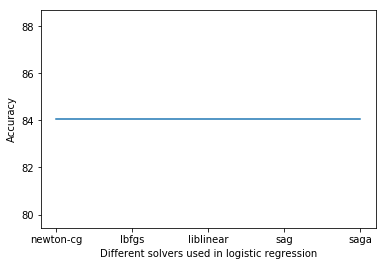

In [11]:
#Logistic regression using inbuilt class
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_wo_pca_scores.append(accuracy_score(y_test, y_pred)*100)
print("Accuracies from cross validation ",np.array(lg_wo_pca_scores))

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train_test, y_train_test)
        y_pred = model.predict(X_validation)
        scores_solvers.append(accuracy_score(y_validation, y_pred)*100)

plt.plot(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()



In [12]:
#Implementation of logistic regression
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)

def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta):
    alpha = 0.1
    num_iter = 20
    for i in range(num_iter):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta)
    y_pred = predict(theta,X_test)
    return theta,y_pred


kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_wo_pca_scores.append(accuracy_score(y_test, y_pred))
print(np.array(lg_m_wo_pca_scores)*100)

[84.18465626 83.28130189 84.40385254 84.30421787 84.78809619 84.19689119
 84.54231434 84.78809619 83.76511226 83.85146805]


In [20]:
#ANN implementation

import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.utils import to_categorical

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
ANN_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(44, input_shape=(44,),activation='relu'),
        keras.layers.Dense(23, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    print(score)
    ANN_wo_pca_scores.append(score)
print("Accuracies from ANN",np.array(ANN_wo_pca_scores))

84.4835602789771
84.25107937562272
84.676187313185
83.72633676519429
15.89610734688455
16.09538992958682
84.11717815862893
83.74518400425136
84.4891723130065
84.44931579646605
Accuracies from ANN [84.48356028 84.25107938 84.67618731 83.72633677 15.89610735 16.09538993
 84.11717816 83.745184   84.48917231 84.4493158 ]


In [16]:
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    linear_svc_wo_pca_scores.append(accuracy_score(y_test, y_pred))

0.8046496180670873
0.7675855197608767
0.7847226834938559
0.5046164065094653
0.4666533811611532
0.7855055134847881
0.8084230104955493
0.786900491563704
0.8444267304370932
0.7991895841636775


In [26]:
#ANN using PCA
from sklearn.decomposition import PCA
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
ANN_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(15, input_shape=(15,),activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    print(score)
    ANN_pca_scores.append(score)
print(np.array(ANN_pca_scores).mean())

84.1713716373298
84.19794088342744
83.93889073397543
84.41713716373297
84.47588680749303
50.385279659891054
15.869536335857578
84.08396439484522
84.07732164208848
84.4891723130065
74.01065015716475


In [27]:
#Linear svm with PCA
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
ANN_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    linear_svc_pca_scores.append(accuracy_score(y_test, y_pred))

0.5767519096645632
0.5384257721687147
0.6130853537030887
0.5345732314845566
0.8452902882954696
0.8434967450511492
0.4935565298259599
0.8111465391258137
0.6971569018201142
0.6174438687392055


In [32]:
#Implementation of logistic regression with PCA
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)

def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta):
    alpha = 0.05
    num_iter = 20
    for i in range(num_iter):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta)
    y_pred = predict(theta,X_test)
    return theta,y_pred


kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_pca_scores.append(accuracy_score(y_test, y_pred))
print(np.array(lg_m_pca_scores)*100)

[49.63135171 50.68747924 50.58120226 50.2025905  50.08635579 49.75421815
 49.82728843 50.43177893 49.86714494 50.61777601]


Accuracies from cross validation  [84.46363334 84.17137164 84.01859847 84.07173696 84.72831141 84.18360569
 84.2234622  84.42274479 84.16367743 84.48252956]


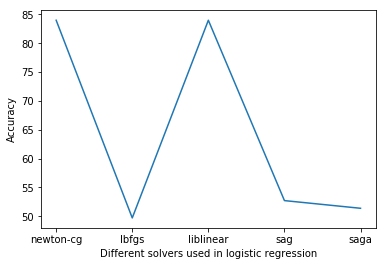

In [29]:
#Logistic regression using inbuilt class with PCA
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_pca_scores.append(accuracy_score(y_test, y_pred)*100)
print("Accuracies from cross validation ",np.array(lg_pca_scores))

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train_test, y_train_test)
        y_pred = model.predict(X_validation)
        scores_solvers.append(accuracy_score(y_validation, y_pred)*100)

plt.plot(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()

